In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import numpy as np
import json

import librosa
import keras
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from keras import regularizers

import matplotlib.pyplot as plt

In [ ]:
data_path = '/content/gdrive/MyDrive/COVID_cough/data/mfcc15_data_audiomentations.json'

In [ ]:
with open(data_path, "r") as fp:
        data = json.load(fp)
        

In [ ]:
X = np.array(data["mfcc"])
y = np.array(data["label"])

In [ ]:
print(X.shape)
print(y.shape)

(1280, 302, 15)
(1280,)


In [ ]:
X=X.reshape(X.shape[0],-1,15,1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1024, 302, 15, 1)
(1024,)
(256, 302, 15, 1)
(256,)


In [ ]:
model=Sequential()

model.add(Conv2D(filters=64,kernel_size=(3,3),input_shape=(302,15,1),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=32,kernel_size=(2,2),activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())

model.add(Dense(256,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=3e-4, l2=3e-3),bias_regularizer=regularizers.l2(3e-3),activity_regularizer=regularizers.l2(3e-4)))
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-2),bias_regularizer=regularizers.l2(1e-2),activity_regularizer=regularizers.l2(1e-3)))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 13, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 6, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 149, 5, 32)        8224      
_________________________________________________________________
batch_normalization (BatchNo (None, 149, 5, 32)        128       
_________________________________________________________________
flatten (Flatten)            (None, 23840)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6103296   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

In [ ]:
optimiser = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimiser,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [ ]:
print(X.shape)
print(y.shape)

(1280, 302, 15, 1)
(1280,)


In [ ]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
for train, test in kfold.split(X, y):
  print(type(X[train]))
  print(X[train].shape)
  print(type(y[test]))
  print(y[test].shape)

<class 'numpy.ndarray'>
(1024, 302, 15, 1)
<class 'numpy.ndarray'>
(256,)
<class 'numpy.ndarray'>
(1024, 302, 15, 1)
<class 'numpy.ndarray'>
(256,)
<class 'numpy.ndarray'>
(1024, 302, 15, 1)
<class 'numpy.ndarray'>
(256,)
<class 'numpy.ndarray'>
(1024, 302, 15, 1)
<class 'numpy.ndarray'>
(256,)
<class 'numpy.ndarray'>
(1024, 302, 15, 1)
<class 'numpy.ndarray'>
(256,)


In [ ]:
fold_dict={}
fold_dict['y_test']=y[test]

In [ ]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

pred_folds_list=[]

cvscores = []
for train, test in kfold.split(X, y):
  
  fold_dict=dict()
  model.fit(X[train], y[train], epochs=200, batch_size=32, verbose=0)
  # evaluate the model
  scores = model.evaluate(X[test], y[test], verbose=0)
  fold_dict['y_test']=y[test]
  fold_dict['y_pred']=model.predict(X[test])
  pred_folds_list.append(fold_dict)
  
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)
 


accuracy: 92.58%
accuracy: 97.27%
accuracy: 98.05%
accuracy: 97.66%
accuracy: 97.66%


In [ ]:

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

96.64% (+/- 2.05%)


 history = model.fit(X, y, batch_size=32, epochs=150)

In [ ]:
#model.save(r'/content/gdrive/MyDrive/COVID_cough/models/FULLcnn_mfcc15audiomentations.h5',save_format='h5')

In [ ]:
from keras.models import load_model

model=load_model('/content/gdrive/MyDrive/COVID_cough/models/FULLcnn_mfcc15audiomentations.h5')

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

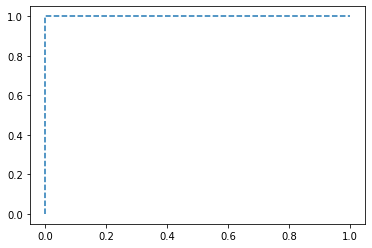

In [ ]:
sum_tests=0
sum_preds=0

for idx,item in enumerate(pred_folds_list):
  sum_tests+=item['y_test']
  sum_preds+=item['y_pred']

avg_tests=sum_tests/len(pred_folds_list)
avg_preds=sum_preds/len(pred_folds_list)

fpr, tpr, thresholds = roc_curve(avg_tests, avg_preds)
plt.plot(fpr, tpr, linestyle='--')

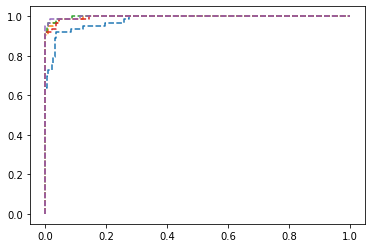

In [ ]:
fpr_list=[]
tpr_list=[]

for idx,item in enumerate(pred_folds_list):
  
  fpr, tpr, thresholds = roc_curve(item['y_test'], item['y_pred'])
  fpr_list.append(fpr)
  tpr_list.append(tpr)

  plt.plot(fpr, tpr, linestyle='--')



  

plt.show()

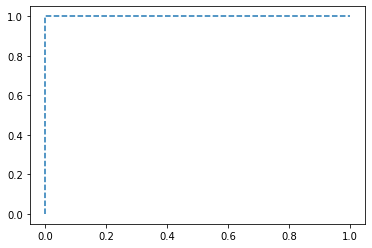

In [ ]:
plt.plot(fpr, tpr, linestyle='--')

In [ ]:


auc = roc_auc_score(y_test, y_pred)
print('AUC: %.3f' % auc)

AUC: 1.000


In [ ]:
#model.save('cnn_auc888.h5',save_format='h5')

In [ ]:
#Lmodel=load_model('cnn_auc888.h5')

In [ ]:
y_test

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0])

In [ ]:
y_preds=[]

for i in y_pred:
  if i >=0.4:
    y_preds.append(1)
  else:
    y_preds.append(0)

y_preds=np.array(y_preds)

In [ ]:
y_preds

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0])

In [ ]:
confusion_matrix(y_test, y_preds)

array([[184,   9],
       [ 12,  51]])

In [ ]:
model.save('/content/gdrive/MyDrive/COVID_cough/models/mfcc15audiomentations.h5',save_format='h5')

Blind set eval

In [ ]:
import pandas as pd

In [ ]:
from keras.models import load_model

model=load_model(r'/content/gdrive/MyDrive/COVID_cough/models/mfcc15audiomentations.h5')

In [ ]:
df=pd.read_csv('/content/gdrive/MyDrive/COVID_cough/test_metadata.csv')

In [ ]:
df

,File_name,Covid_status,Gender,Nationality
0,ehmkjtFk_cough,?,m,O
1,UCxrHdoP_cough,?,m,I
2,afJveyWf_cough,?,f,I
3,ckgXCsSh_cough,?,m,I
4,KprOlhNx_cough,?,m,I
...,...,...,...,...
228,WxtUSymX_cough,?,f,I
229,VYFvgWMm_cough,?,f,I
230,coWKLPUF_cough,?,f,I
231,XvOqdxQJ_cough,?,m,I


In [ ]:
data_path = '/content/gdrive/MyDrive/COVID_cough/data/Evaluations/mfcc15_blind_set.json'

In [ ]:
with open(data_path, "r") as fp:
        data = json.load(fp)
        

In [ ]:
X = np.array(data["mfcc"])
X=X.reshape(X.shape[0],-1,15,1)
X.shape

(233, 302, 15, 1)

In [ ]:
y_pred_probs=model.predict(X)

In [ ]:
y=list(y_pred_probs.reshape(-1))

In [ ]:
dicto={'File_name':list(df['File_name']),'Probability':y}

In [ ]:
results=pd.DataFrame(dicto)

In [ ]:
results.to_csv('15mfcc_audiomentation_Blind_Set_results.csv',index=False)

In [ ]:
x=pd.read_csv('15mfcc_audiomentation_Blind_Set_results.csv')

In [ ]:
type(x['Probability'][0])

numpy.float64

Val Folds eval

In [ ]:
df=pd.read_csv('/content/gdrive/MyDrive/COVID_cough/Val_set.csv')

In [ ]:
df

,file_name
0,PQFgfbUS_cough
1,dpITIaDY_cough
2,IzXaepIB_cough
3,ZVKSsFiW_cough
4,LFqjhpiv_cough
...,...
1085,tWjZnGra_cough
1086,dAlFPhsp_cough
1087,gjLXOetR_cough
1088,WJAIhgpc_cough


In [ ]:
data_path = '/content/gdrive/MyDrive/COVID_cough/data/Evaluations/mfcc15_val_folds.json'

In [ ]:
with open(data_path, "r") as fp:
        data = json.load(fp)
        

In [ ]:
X = np.array(data["mfcc"])
X=X.reshape(X.shape[0],-1,15,1)
X.shape

(1090, 302, 15, 1)

In [ ]:
y_pred_probs=model.predict(X)

In [ ]:
y=list(y_pred_probs.reshape(-1))

In [ ]:
dicto={'File_name':list(df['file_name']),'Probability':y}

In [ ]:
results=pd.DataFrame(dicto)

In [ ]:
results.to_csv('15mfcc_audiomentations_val_set_results.csv',index=False)

In [ ]:
x=pd.read_csv('15mfcc_audiomentations_val_set_results.csv')

In [ ]:
type(x['Probability'][0])

numpy.float64